In [30]:
import pandas as pd
import os
import glob

# =========================
# FOLDER PATH
# =========================
input_folder = "fundamental_data"      # folder containing raw CSVs
output_folder = "clean_fundamental_data"

# Create output folder if not exists
os.makedirs(output_folder, exist_ok=True)

# =========================
# INDICATORS TO KEEP
# =========================
relevant_indicators = [
    "Net Sales/Income from operations",
    "Total Income From Operations",
    "Net Profit/(Loss) For the Period",
    "P/L Before Tax",
    "Interest",
    "Depreciation",
    "Basic EPS",
    "Equity Share Capital"
]


# =========================
# PROCESS ALL CSV FILES
# =========================
files = glob.glob(os.path.join(input_folder, "*.csv"))

for input_file in files:

    print("Processing:", input_file)

    df = pd.read_csv(input_file)

    # Clean column names
    df.columns = df.columns.str.strip()

    # Filter relevant rows
    filtered = df[df["Indicators"].isin(relevant_indicators)]

    #remove unnamed columns
    filtered = filtered.loc[:, ~filtered.columns.str.contains('Unnamed')]

    # Transpose
    filtered.set_index("Indicators", inplace=True)
    clean_df = filtered.T

    # Reset index
    clean_df.reset_index(inplace=True)
    clean_df.rename(columns={"index": "Quarter"}, inplace=True)

    #remove unnamed columns
    clean_df = clean_df.loc[:, ~clean_df.columns.str.contains('Unnamed')]

    # =========================
    # OUTPUT FILE NAME
    # =========================
    filename = os.path.basename(input_file)
    output_file = os.path.join(output_folder, filename.replace(".csv", "_clean.csv"))

    clean_df.to_csv(output_file, index=False)

    print("✅ Saved:", output_file)

print("\n🎉 All files processed successfully!")


Processing: fundamental_data\bhartiairtel.csv
✅ Saved: clean_fundamental_data\bhartiairtel_clean.csv
Processing: fundamental_data\hdfc_fundamentals.csv
✅ Saved: clean_fundamental_data\hdfc_fundamentals_clean.csv
Processing: fundamental_data\hul_fundamentals.csv
✅ Saved: clean_fundamental_data\hul_fundamentals_clean.csv
Processing: fundamental_data\infy_fuindamentals.csv
✅ Saved: clean_fundamental_data\infy_fuindamentals_clean.csv
Processing: fundamental_data\mm_fundamentals.csv
✅ Saved: clean_fundamental_data\mm_fundamentals_clean.csv
Processing: fundamental_data\reliance_fundamentals.csv
✅ Saved: clean_fundamental_data\reliance_fundamentals_clean.csv

🎉 All files processed successfully!


In [25]:
import yfinance as yf
import pandas as pd
import os

# =========================
# STOCK LIST
# =========================
stocks = {
    "RELIANCE": "RELIANCE.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "INFY": "INFY.NS",
    "M&M": "M&M.NS",
    "BHARTIARTL": "BHARTIARTL.NS",
    "HUL": "HINDUNILVR.NS"
}

start_date = "2020-01-01"
end_date = "2026-01-01"

os.makedirs("market_data/train", exist_ok=True)
os.makedirs("market_data/test", exist_ok=True)

# =========================
# LOOP THROUGH STOCKS
# =========================
for name, ticker in stocks.items():

    print(f"\nDownloading {name}...")

    data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=False
    )

    data.reset_index(inplace=True)

    # Split
    train = data[data["Date"] < "2025-10-01"]
    test = data[data["Date"] >= "2025-10-01"]

    # Save
    train.to_csv(f"market_data/train/{name}_train.csv", index=False)
    test.to_csv(f"market_data/test/{name}_test.csv", index=False)

    print(f"✅ Saved {name}")

print("\n🎉 All market data downloaded!")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved RELIANCE

✅ Saved HDFCBANK




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Saved INFY

✅ Saved M&M

✅ Saved BHARTIARTL

✅ Saved HUL

🎉 All market data downloaded!


,date,adj close,close,high,low,open,volume
0,2020-01-01,605.529296875,639.299988,640.0,635.2999877929688,638.0499877929688,3673698
1,2020-01-02,609.3890991210938,643.375000,644.0,639.5,639.5,6137166
2,2020-01-03,600.6987915039062,634.200012,642.5,631.7999877929688,641.0999755859375,10855550
3,2020-01-06,587.6987915039062,620.474976,630.9000244140625,618.0,630.0,10890186
4,2020-01-07,597.0048217773438,630.299988,635.7249755859375,626.125,629.4500122070312,14724494


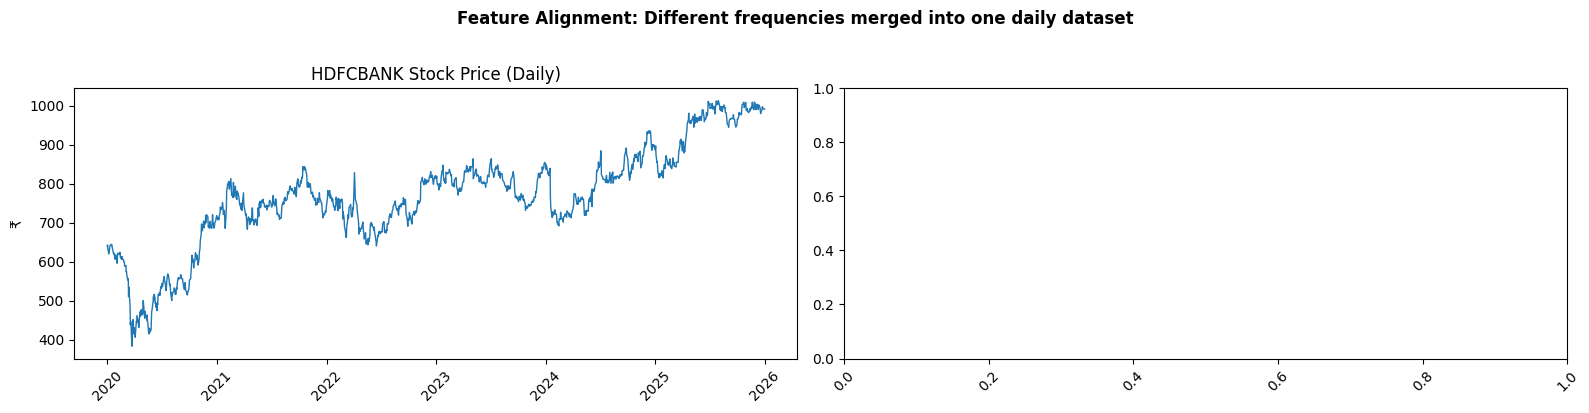

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ============================================================
# 1. LOAD AND PREPARE DATA
# ============================================================
name = "HDFCBANK"

train_path = f"market_data/train/{name}_train.csv"
test_path = f"market_data/test/{name}_test.csv"

if os.path.exists(train_path) and os.path.exists(test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    df = pd.concat([df_train, df_test], ignore_index=True)
else:
    print("Files not found! Please run your download script first.")
    raise SystemExit

# ------------------------------------------------------------
# CLEANING
# ------------------------------------------------------------

# Make column names lowercase
df.columns = [c.lower() for c in df.columns]

# Remove accidental ticker rows
df = df[df['close'] != 'HDFCBANK.NS']

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert price column to numeric
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Drop bad rows
df = df.dropna(subset=['date', 'close'])

# VERY IMPORTANT: sort by date
df = df.sort_values('date')

# Reset index (optional but clean)
df = df.reset_index(drop=True)

display(df.head())

# ============================================================
# 2. PLOTTING
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Main stock price plot
axes[0].plot(df['date'], df['close'], linewidth=1)
axes[0].set_title('HDFCBANK Stock Price (Daily)')
axes[0].set_ylabel('₹')

# Nice date formatting
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate ticks
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.suptitle(
    'Feature Alignment: Different frequencies merged into one daily dataset',
    fontsize=12,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open Volume
Ticker          INR=X      INR=X      INR=X      INR=X  INR=X
Date                                                         
2020-01-01  71.275803  71.430000  71.029999  71.275803      0
2020-01-02  71.025002  71.405502  71.025002  71.025002      0
2020-01-03  71.415001  71.995003  71.229797  71.415001      0
2020-01-06  71.731003  72.190002  71.703003  71.720001      0
2020-01-07  71.787003  72.032600  71.668999  72.019997      0
...               ...        ...        ...        ...    ...
2025-12-24  89.507896  89.865700  89.422997  89.507896      0
2025-12-26  90.105904  90.109001  89.548698  90.105904      0
2025-12-29  89.829300  90.355003  89.763603  89.814301      0
2025-12-30  89.900002  89.990097  89.685799  89.900200      0
2025-12-31  89.769402  89.938004  89.643997  89.769699      0

[1562 rows x 5 columns]



C:\Users\panum\AppData\Local\Temp\ipykernel_28828\2987482559.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_inr['USDINR_ret'] = np.log(usd_inr['USDINR']).diff()


,USDINR,Date,USDINR_ret
0,71.275803,2020-01-01,NaN
1,71.025002,2020-01-02,-0.003525
2,71.415001,2020-01-03,0.005476
3,71.731003,2020-01-06,0.004415
4,71.787003,2020-01-07,0.000780


✅ Saved USD/INR data to macro_data/usd_inr.csv


,Date,Price,Open,High,Low,Change %
0,31-12-2025,6.588,6.576,6.604,6.569,0.18%
1,30-12-2025,6.576,6.595,6.602,6.576,-0.29%
2,29-12-2025,6.595,6.560,6.595,6.560,0.53%
3,26-12-2025,6.560,6.538,6.574,6.537,0.34%
4,25-12-2025,6.538,6.538,6.538,6.538,0.00%


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million)
0,02-Jan-2026,2.57,2.90,2.55,3.35,5.5,5.5,8.35,-,-,-,6.69,3.0,18.0,5.25,5.00,"6,86,800.98"
1,26-Dec-2025,5.24,3.52,3.08,3.35,5.5,5.5,8.35,5.26,5.48,5.54,6.65,3.0,18.0,5.25,5.00,"6,96,610.43"
2,19-Dec-2025,5.05,3.63,3.21,3.35,5.5,5.5,8.35,5.28,5.50,5.50,6.67,3.0,18.0,5.25,5.00,"6,93,317.71"
3,12-Dec-2025,3.55,2.93,2.84,3.35,5.5,5.5,8.35,5.27,5.48,5.49,6.66,3.0,18.0,5.25,5.00,"6,88,949.39"
4,05-Dec-2025,2.92,2.65,2.56,3.35,5.5,5.5,8.35,5.35,5.53,5.55,6.55,3.0,18.0,5.25,5.00,"6,87,260.37"


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open Volume
Ticker           BZ=F       BZ=F       BZ=F       BZ=F   BZ=F
Date                                                         
2020-01-02  66.250000  66.570000  65.730003  66.470001  25810
2020-01-03  68.599998  69.480003  66.220001  66.290001  78848
2020-01-06  68.910004  70.720001  68.190002  69.070000  51933
2020-01-07  68.269997  68.739998  67.650002  68.580002  41178
2020-01-08  65.440002  71.989998  64.940002  68.470001  85232
...               ...        ...        ...        ...    ...
2025-12-24  62.240002  62.720001  62.020000  62.430000  14966
2025-12-26  60.639999  62.689999  60.590000  62.349998   9687
2025-12-29  61.939999  62.150002  60.950001  61.040001   9170
2025-12-30  61.919998  62.330002  61.509998  61.700001  30567
2025-12-31  60.849998  61.910000  60.619999  61.270000  30919

[1511 rows x 5 columns]


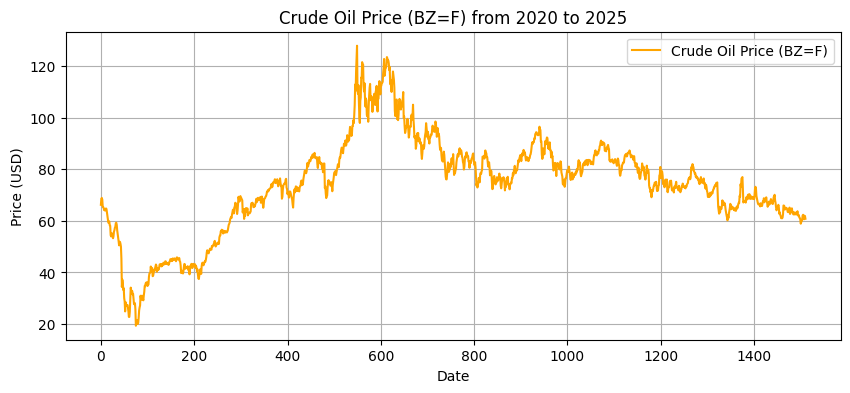

,Date,CRUDE_ret,CRUDE
0,2020-01-02,NaN,66.250000
1,2020-01-03,0.034857,68.599998
2,2020-01-06,0.004509,68.910004
3,2020-01-07,-0.009331,68.269997
4,2020-01-08,-0.042337,65.440002


✅ Saved Crude Oil data to macro_data/crude_oil.csv


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

start = "2020-01-01"
end   = "2026-01-01"

usd_inr = yf.download("INR=X", start=start, end=end, auto_adjust=True)
print(usd_inr)
#clean remove improper rows
#columns 0 and 1 as date and close
#we have to rename the columns to date and close 
usd_inr = usd_inr.reset_index()   # ⭐ bring Date out of index
usd_inr_data = usd_inr[['Date', 'Close']]
usd_inr_data.columns = ['Date', 'USDINR']

usd_inr = usd_inr_data[['USDINR', 'Date']]
usd_inr.columns = ['USDINR', 'Date']
# Convert to log returns (stationarity)
usd_inr['USDINR_ret'] = np.log(usd_inr['USDINR']).diff()


display(usd_inr.head())
usd_csv_path = "macro_data/usd_inr.csv"
usd_inr.to_csv(usd_csv_path, index=False)
print(f"✅ Saved USD/INR data to {usd_csv_path}")

india_10y = pd.read_csv("macro_data\India 10-Year Bond Yield Historical Data.csv")
display(india_10y.head())

rbi_macro_data = pd.read_csv(r"macro_data\rbi_macro_indicators.csv")
display(rbi_macro_data.head())

crude = yf.download("BZ=F", start=start, end=end)

crude = crude.reset_index()
crude = crude[['Date', 'Close']]

#plot crude price
plt.figure(figsize=(10, 4))
plt.plot(crude.index, crude['Close'], label='Crude Oil Price (BZ=F)', color='orange')
plt.title('Crude Oil Price (BZ=F) from 2020 to 2025')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


crude.columns = ['Date', 'CRUDE']

crude['CRUDE_ret'] = np.log(crude['CRUDE']).diff()

crude = crude[['Date', 'CRUDE_ret', 'CRUDE']]
display(crude.head())
crude_csv_path = "macro_data/crude_oil.csv"
crude.to_csv(crude_csv_path, index=False)
print(f"✅ Saved Crude Oil data to {crude_csv_path}")

In [ ]:
# =========================================================
# PROFESSIONAL NEWS PIPELINE (STOCK + MACRO)
# 6-MONTH BATCHING + STORAGE
# =========================================================


from serpapi import GoogleSearch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import datetime
import os

# =========================================================
# CONFIG
# =========================================================

API_KEY = ""

STOCKS = ["RELIANCE", "HDFCBANK", "INFY", "M&M", "BHARTIARTL", "HUL"]

MACRO_QUERY = "India economy OR RBI OR inflation OR crude OR tariff OR interest rates"

START_YEAR = 2020
END_YEAR   = 2025

BASE_DIR = "news_data"
os.makedirs(BASE_DIR, exist_ok=True)

# =========================================================
# LOAD FINBERT
# =========================================================

print("Loading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()
print("FinBERT Loaded\n")

def finbert_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs[0][0].item() - probs[0][1].item()

# =========================================================
# FETCH FUNCTION (WITH DATE FILTERING)
# =========================================================

def fetch_news(query, start_date, end_date):
    
    full_query = f"{query} after:{start_date} before:{end_date}"
    
    params = {
        "engine": "google_news",
        "q": full_query,
        "api_key": API_KEY,
        "hl": "en",
        "gl": "in"
    }
    
    search = GoogleSearch(params)
    results = search.get_dict()
    
    articles = []
    
    for item in results.get("news_results", []):
        articles.append({
            "date": item.get("date"),
            "headline": item.get("title"),
            "source": item.get("source", {}).get("name")
        })
    
    return pd.DataFrame(articles)

# =========================================================
# DATE PARSER
# =========================================================

from datetime import datetime, timedelta

def parse_google_date(date_str):
    if pd.isna(date_str):
        return None
    date_str = str(date_str).lower()
    now = datetime.now()
    
    try:
        if "hour" in date_str:
            return now - timedelta(hours=int(date_str.split()[0]))
        elif "day" in date_str:
            return now - timedelta(days=int(date_str.split()[0]))
        elif "week" in date_str:
            return now - timedelta(weeks=int(date_str.split()[0]))
        elif "month" in date_str:
            return now - timedelta(days=30*int(date_str.split()[0]))
        else:
            return pd.to_datetime(date_str)
    except:
        return None

# =========================================================
# MAIN COLLECTION LOOP
# =========================================================

def collect_news(label, query):

    print(f"\nCollecting: {label}")
    
    all_data = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        
        periods = [
            (f"{year}-01-01", f"{year}-07-01"),
            (f"{year}-07-01", f"{year+1}-01-01")
        ]
        
        for start, end in periods:
            
            print(f"{label} | {start} → {end}")
            
            df = fetch_news(query, start, end)
            
            if df.empty:
                continue
            
            all_data.append(df)
    
    if not all_data:
        print("No data found.")
        return
    
    combined = pd.concat(all_data)
    display(combined.head(20))
    
    # Clean dates
    # Clean and standardize date strings
    combined["date"] = (
        combined["date"]
        .str.replace(" UTC", "", regex=False)
        .str.replace(",", "", regex=False)
    )

    combined["date"] = pd.to_datetime(
        combined["date"],
        format="%m/%d/%Y %I:%M %p %z",
        errors="coerce"
    )

    combined = combined.dropna(subset=["date"])

    print("After datetime conversion:", len(combined))
    print(combined.head())
    
    print(f"Total usable articles: {len(combined)}")
    
    # Sentiment scoring
    tqdm.pandas()
    combined["sentiment"] = combined["headline"].progress_apply(finbert_score)
    
    # Save raw + scored
    combined.to_csv(f"{BASE_DIR}/{label}_full_news.csv", index=False)
    
    # Daily aggregation
    daily = (
        combined
        .groupby(combined["date"].dt.date)["sentiment"]
        .mean()
        .to_frame(name=f"{label}_sentiment")
    )
    
    daily.index = pd.to_datetime(daily.index)
    daily = daily.shift(1)
    
    daily.to_csv(f"{BASE_DIR}/{label}_daily_sentiment.csv")
    
    print(f"{label} saved successfully\n")

# =========================================================
# RUN FOR STOCKS
# =========================================================

for stock in STOCKS:
    collect_news(stock, f"{stock} stock India")

# =========================================================
# RUN FOR MACRO NEWS
# =========================================================

collect_news("MACRO", MACRO_QUERY)

print("\nALL NEWS COLLECTION COMPLETE ✅")


Loading FinBERT...
FinBERT Loaded


Collecting: RELIANCE
RELIANCE | 2020-01-01 → 2020-07-01
RELIANCE | 2020-07-01 → 2021-01-01
RELIANCE | 2021-01-01 → 2021-07-01
RELIANCE | 2021-07-01 → 2022-01-01
RELIANCE | 2022-01-01 → 2022-07-01
RELIANCE | 2022-07-01 → 2023-01-01
RELIANCE | 2023-01-01 → 2023-07-01
RELIANCE | 2023-07-01 → 2024-01-01
RELIANCE | 2024-01-01 → 2024-07-01
RELIANCE | 2024-07-01 → 2025-01-01
RELIANCE | 2025-01-01 → 2025-07-01
RELIANCE | 2025-07-01 → 2026-01-01


,date,headline,source
0,"05/16/2020, 07:00 AM, +0000 UTC",'New Reliance for a New India',The Times of India
1,"06/24/2020, 07:00 AM, +0000 UTC",How a Change in a Rule by SEBI Helped Reliance...,newsclick.in
2,"06/01/2020, 07:00 AM, +0000 UTC",India’s Most Valuable Brands 2020: Reliance In...,Moneycontrol
3,"04/26/2020, 07:00 AM, +0000 UTC",Ambani Tests WhatsApp-Backed Online Store in L...,Bloomberg
4,"05/16/2020, 07:00 AM, +0000 UTC",Rights issue of Mukesh Ambani’s Reliance Indus...,The Hindu
5,"06/19/2020, 07:00 AM, +0000 UTC",Reliance Industries becomes India's first firm...,Mint
6,"06/20/2020, 07:00 AM, +0000 UTC",11 deals for $15 billion in 10 weeks: Why Indi...,Fortune
7,"06/05/2020, 07:00 AM, +0000 UTC",Ambani reshapes Reliance for digital India wit...,Nikkei Asia
8,"06/02/2020, 07:00 AM, +0000 UTC",RIL's mega right issue world's biggest by a no...,The Economic Times
9,"04/21/2020, 07:00 AM, +0000 UTC",Facebook invests $5.7 billion in Jio Platforms...,CNBC


After datetime conversion: 698
                       date  \
0 2020-05-16 07:00:00+00:00   
1 2020-06-24 07:00:00+00:00   
2 2020-06-01 07:00:00+00:00   
3 2020-04-26 07:00:00+00:00   
4 2020-05-16 07:00:00+00:00   

                                            headline              source  
0                     'New Reliance for a New India'  The Times of India  
1  How a Change in a Rule by SEBI Helped Reliance...        newsclick.in  
2  India’s Most Valuable Brands 2020: Reliance In...        Moneycontrol  
3  Ambani Tests WhatsApp-Backed Online Store in L...           Bloomberg  
4  Rights issue of Mukesh Ambani’s Reliance Indus...           The Hindu  
Total usable articles: 698


100%|██████████| 698/698 [00:32<00:00, 21.53it/s]


RELIANCE saved successfully


Collecting: HDFCBANK
HDFCBANK | 2020-01-01 → 2020-07-01
HDFCBANK | 2020-07-01 → 2021-01-01
HDFCBANK | 2021-01-01 → 2021-07-01
HDFCBANK | 2021-07-01 → 2022-01-01
HDFCBANK | 2022-01-01 → 2022-07-01
HDFCBANK | 2022-07-01 → 2023-01-01
HDFCBANK | 2023-01-01 → 2023-07-01


KeyboardInterrupt: 

In [74]:
#RELIANCE merging data
import pandas as pd
import os
reliance_stock_train = pd.read_csv("market_data/train/RELIANCE_train.csv")
reliance_stock_test = pd.read_csv("market_data/test/RELIANCE_test.csv")

#mergeing
reliance_stock = pd.concat([reliance_stock_train, reliance_stock_test], ignore_index=True)
#delete first row 
reliance_stock = reliance_stock[reliance_stock['Close'] != 'RELIANCE.NS']
#convert date to datetime
reliance_stock['Date'] = pd.to_datetime(reliance_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
reliance_stock['Close'] = pd.to_numeric(reliance_stock['Close'], errors='coerce')
reliance_stock['Adj Close'] = pd.to_numeric(reliance_stock['Adj Close'], errors='coerce')

display(reliance_stock.head())
# display(reliance_stock.tail())

reliance_fundamentals = pd.read_csv("clean_fundamental_data/reliance_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

reliance_fundamentals['QuarterDate'] = reliance_fundamentals['Quarter'].apply(parse_quarter_date)

reliance_fundamentals = reliance_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_reliance_data = pd.DataFrame()
for i in range(len(reliance_fundamentals)):
    quarter_date = reliance_fundamentals.loc[i, 'QuarterDate']
    if i < len(reliance_fundamentals) - 1:
        next_quarter_date = reliance_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = reliance_stock['Date'].max()  # Default end date
    
    mask = (reliance_stock['Date'] > quarter_date) & (reliance_stock['Date'] <= next_quarter_date)
    temp_stock_data = reliance_stock[mask].copy()
    
    for col in reliance_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = reliance_fundamentals.loc[i, col]
    
    final_reliance_data = pd.concat([final_reliance_data, temp_stock_data], ignore_index=True)

display(reliance_fundamentals.head())
#create P/EPS column
final_reliance_data['P/EPS'] = final_reliance_data['Adj Close'] / final_reliance_data['Basic EPS']

display(final_reliance_data.head(90))
display(final_reliance_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_reliance_data = final_reliance_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_reliance_data = pd.merge_asof(
    final_reliance_data,
    usd,
    on="Date",
    direction="backward"
)

final_reliance_data = pd.merge_asof(
    final_reliance_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_reliance_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_reliance_data = pd.merge_asof(
    final_reliance_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_reliance_data = pd.merge_asof(
    final_reliance_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_reliance_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_reliance_data = pd.merge_asof(
    final_reliance_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load reliance sentiment data and merge
reliance_sentiment = pd.read_csv("news_data/RELIANCE_daily_sentiment.csv")
reliance_sentiment = reliance_sentiment.rename(columns={"date": "Date"})

reliance_sentiment['Date'] = pd.to_datetime(reliance_sentiment['Date'])
reliance_sentiment = reliance_sentiment.sort_values('Date')
final_reliance_data = pd.merge_asof(
    final_reliance_data,
    reliance_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_reliance_data['MACRO_sentiment'] = final_reliance_data['MACRO_sentiment'].fillna(0)
final_reliance_data['RELIANCE_sentiment'] = final_reliance_data['RELIANCE_sentiment'].fillna(0)

display(final_reliance_data.head(20))
final_reliance_data.to_csv("final_datasets/reliance_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,675.324219,690.138306,698.1387329101562,688.2639770507812,693.978515625,14004468
2,2020-01-02,686.821228,701.887512,704.4705200195312,691.2355346679688,691.2355346679688,17710316
3,2020-01-03,687.648804,702.733276,704.79052734375,696.2643432617188,700.8359985351562,20984698
4,2020-01-06,671.700684,686.435303,698.5044555664062,684.835205078125,694.8928833007812,24519177
5,2020-01-07,682.034546,696.995850,701.5217895507812,691.9212646484375,694.4356689453125,16683622


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31
1,Mar '20,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31
2,Jun '20,"88,253","88,253","6,308","6,735","13,186","12,926","6,445",12.92,2020-06-30
3,Sep '20,"1,16,195","1,16,195","6,626","6,084","10,484","10,497","6,445",14.84,2020-09-30
4,Dec '20,"1,17,860","1,17,860","6,665","4,326","14,907","14,819","6,445",20.33,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,675.324219,690.138306,698.1387329101562,688.2639770507812,693.978515625,14004468,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,36.782365
1,2020-01-02,686.821228,701.887512,704.4705200195312,691.2355346679688,691.2355346679688,17710316,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.408564
2,2020-01-03,687.648804,702.733276,704.79052734375,696.2643432617188,700.8359985351562,20984698,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.453639
3,2020-01-06,671.700684,686.435303,698.5044555664062,684.835205078125,694.8928833007812,24519177,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,36.585005
4,2020-01-07,682.034546,696.995850,701.5217895507812,691.9212646484375,694.4356689453125,16683622,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.147851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,698.676147,714.002441,722.277099609375,702.7103881835938,706.322021484375,84262770,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,41.712009
86,2020-05-11,705.386414,720.859924,738.3236694335938,718.8026733398438,722.3228149414062,67085063,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,42.112622
87,2020-05-12,661.747070,676.263306,716.9968872070312,669.7487182617188,715.3739013671875,100683202,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,39.507288
88,2020-05-13,675.787231,690.611450,704.7102661132812,671.020751953125,704.7102661132812,66430125,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,40.345506


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,1558.199951,1558.199951,1575.699951171875,1553.5999755859375,1572.699951171875,8815745,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,116.110280
1483,2025-12-26,1559.199951,1559.199951,1561.0,1554.300048828125,1554.699951171875,2311495,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,116.184795
1484,2025-12-29,1545.599976,1545.599976,1558.0999755859375,1543.5999755859375,1554.9000244140625,5972105,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,115.171384
1485,2025-12-30,1539.800049,1539.800049,1553.5999755859375,1537.800048828125,1547.0,8815884,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,114.739199
1486,2025-12-31,1570.400024,1570.400024,1577.0,1541.0,1541.0,5771830,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,117.019376


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\4084459581.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,RELIANCE_sentiment
0,2020-01-01,675.324219,690.138306,698.1387329101562,688.2639770507812,693.978515625,14004468,"1,53,179","1,53,179","5,545",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2020-01-02,686.821228,701.887512,704.4705200195312,691.2355346679688,691.2355346679688,17710316,"1,53,179","1,53,179","5,545",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2020-01-03,687.648804,702.733276,704.79052734375,696.2643432617188,700.8359985351562,20984698,"1,53,179","1,53,179","5,545",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
3,2020-01-06,671.700684,686.435303,698.5044555664062,684.835205078125,694.8928833007812,24519177,"1,53,179","1,53,179","5,545",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
4,2020-01-07,682.034546,696.995850,701.5217895507812,691.9212646484375,694.4356689453125,16683622,"1,53,179","1,53,179","5,545",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
5,2020-01-08,676.912354,691.761292,701.4989013671875,690.3212280273438,692.6070556640625,16047902,"1,53,179","1,53,179","5,545",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
6,2020-01-09,692.502563,707.693542,708.6078491210938,700.0360107421875,703.3961791992188,14982742,"1,53,179","1,53,179","5,545",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
7,2020-01-10,692.346069,707.533508,712.2423095703125,703.8761596679688,709.4764404296875,12478359,"1,53,179","1,53,179","5,545",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.000000
8,2020-01-13,690.578979,705.727722,712.585205078125,703.3047485351562,706.3449096679688,18282382,"1,53,179","1,53,179","5,545",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,0.000000
9,2020-01-14,684.181885,699.190247,708.6078491210938,695.7386474609375,704.0361938476562,15816535,"1,53,179","1,53,179","5,545",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,0.000000


In [79]:
#HDFC merging data
import pandas as pd
import os
HDFC_stock_train = pd.read_csv("market_data/train/HDFCBANK_train.csv")
HDFC_stock_test = pd.read_csv("market_data/test/HDFCBANK_test.csv")

#mergeing
HDFC_stock = pd.concat([HDFC_stock_train, HDFC_stock_test], ignore_index=True)
#delete first row 
HDFC_stock = HDFC_stock[HDFC_stock['Close'] != 'HDFCBANK.NS']
#convert date to datetime
HDFC_stock['Date'] = pd.to_datetime(HDFC_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
HDFC_stock['Close'] = pd.to_numeric(HDFC_stock['Close'], errors='coerce')
HDFC_stock['Adj Close'] = pd.to_numeric(HDFC_stock['Adj Close'], errors='coerce')

display(HDFC_stock.head())
# display(HDFC_stock.tail())

HDFC_fundamentals = pd.read_csv("clean_fundamental_data/hdfc_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

HDFC_fundamentals['QuarterDate'] = HDFC_fundamentals['Quarter'].apply(parse_quarter_date)

HDFC_fundamentals = HDFC_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_HDFC_data = pd.DataFrame()
for i in range(len(HDFC_fundamentals)):
    quarter_date = HDFC_fundamentals.loc[i, 'QuarterDate']
    if i < len(HDFC_fundamentals) - 1:
        next_quarter_date = HDFC_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = HDFC_stock['Date'].max()  # Default end date
    
    mask = (HDFC_stock['Date'] > quarter_date) & (HDFC_stock['Date'] <= next_quarter_date)
    temp_stock_data = HDFC_stock[mask].copy()
    
    for col in HDFC_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = HDFC_fundamentals.loc[i, col]
    
    final_HDFC_data = pd.concat([final_HDFC_data, temp_stock_data], ignore_index=True)

display(HDFC_fundamentals.head())
#create P/EPS column
final_HDFC_data['P/EPS'] = final_HDFC_data['Adj Close'] / final_HDFC_data['Basic EPS']

display(final_HDFC_data.head(90))
display(final_HDFC_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_HDFC_data = final_HDFC_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    usd,
    on="Date",
    direction="backward"
)

final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_HDFC_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_HDFC_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load HDFC sentiment data and merge
HDFC_sentiment = pd.read_csv("news_data/HDFCBANK_daily_sentiment.csv")
HDFC_sentiment = HDFC_sentiment.rename(columns={"date": "Date"})

HDFC_sentiment['Date'] = pd.to_datetime(HDFC_sentiment['Date'])
HDFC_sentiment = HDFC_sentiment.sort_values('Date')
final_HDFC_data = pd.merge_asof(
    final_HDFC_data,
    HDFC_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_HDFC_data['MACRO_sentiment'] = final_HDFC_data['MACRO_sentiment'].fillna(0)
final_HDFC_data['HDFCBANK_sentiment'] = final_HDFC_data['HDFCBANK_sentiment'].fillna(0)

display(final_HDFC_data.head(20))
final_HDFC_data.to_csv("final_datasets/HDFC_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,605.529297,639.299988,640.0,635.2999877929688,638.0499877929688,3673698
2,2020-01-02,609.389099,643.375000,644.0,639.5,639.5,6137166
3,2020-01-03,600.698792,634.200012,642.5,631.7999877929688,641.0999755859375,10855550
4,2020-01-06,587.698792,620.474976,630.9000244140625,618.0,630.0,10890186
5,2020-01-07,597.004822,630.299988,635.7249755859375,626.125,629.4500122070312,14724494


,Quarter,Depreciation,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,--,"10,249","7,659",547,14.0,2019-12-31
1,Mar '20,--,"9,681","7,296",548,13.3,2020-03-31
2,Jun '20,--,"9,339","6,940",549,12.6,2020-06-30
3,Sep '20,--,"10,377","7,711",550,14.0,2020-09-30
4,Dec '20,--,"11,813","8,760",550,15.9,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Depreciation,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,605.529297,639.299988,640.0,635.2999877929688,638.0499877929688,3673698,--,"10,249","7,659",547,14.0,2019-12-31,43.252093
1,2020-01-02,609.389099,643.375000,644.0,639.5,639.5,6137166,--,"10,249","7,659",547,14.0,2019-12-31,43.527793
2,2020-01-03,600.698792,634.200012,642.5,631.7999877929688,641.0999755859375,10855550,--,"10,249","7,659",547,14.0,2019-12-31,42.907057
3,2020-01-06,587.698792,620.474976,630.9000244140625,618.0,630.0,10890186,--,"10,249","7,659",547,14.0,2019-12-31,41.978485
4,2020-01-07,597.004822,630.299988,635.7249755859375,626.125,629.4500122070312,14724494,--,"10,249","7,659",547,14.0,2019-12-31,42.643202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,439.986786,464.524994,471.9750061035156,462.6000061035156,471.0,20807484,--,"9,681","7,296",548,13.3,2020-03-31,33.081713
86,2020-05-11,433.711700,457.899994,477.0,457.0,468.5,28550784,--,"9,681","7,296",548,13.3,2020-03-31,32.609902
87,2020-05-12,426.963074,450.774994,454.70001220703125,435.54998779296875,450.5,49568418,--,"9,681","7,296",548,13.3,2020-03-31,32.102487
88,2020-05-13,439.323761,463.825012,480.0,461.04998779296875,475.5,44346966,--,"9,681","7,296",548,13.3,2020-03-31,33.031862


,Date,Adj Close,Close,High,Low,Open,Volume,Depreciation,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,997.200012,997.200012,999.4000244140625,993.0,993.0,13699996,--,"26,658","20,363","1,536",12.78,2025-09-30,78.028170
1483,2025-12-26,992.099976,992.099976,997.2000122070312,987.7000122070312,996.0,9360853,--,"26,658","20,363","1,536",12.78,2025-09-30,77.629106
1484,2025-12-29,991.700012,991.700012,997.4000244140625,987.2000122070312,993.0999755859375,13545749,--,"26,658","20,363","1,536",12.78,2025-09-30,77.597810
1485,2025-12-30,990.900024,990.900024,995.0,982.2000122070312,990.2000122070312,33155849,--,"26,658","20,363","1,536",12.78,2025-09-30,77.535213
1486,2025-12-31,991.200012,991.200012,997.5999755859375,987.5999755859375,991.0,10963454,--,"26,658","20,363","1,536",12.78,2025-09-30,77.558686


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\2716242355.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Depreciation,P/L Before Tax,Net Profit/(Loss) For the Period,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,HDFCBANK_sentiment
0,2020-01-01,605.529297,639.299988,640.0,635.2999877929688,638.0499877929688,3673698,--,"10,249","7,659",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2020-01-02,609.389099,643.375000,644.0,639.5,639.5,6137166,--,"10,249","7,659",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2020-01-03,600.698792,634.200012,642.5,631.7999877929688,641.0999755859375,10855550,--,"10,249","7,659",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
3,2020-01-06,587.698792,620.474976,630.9000244140625,618.0,630.0,10890186,--,"10,249","7,659",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
4,2020-01-07,597.004822,630.299988,635.7249755859375,626.125,629.4500122070312,14724494,--,"10,249","7,659",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
5,2020-01-08,595.441956,628.650024,631.0750122070312,620.0250244140625,623.4749755859375,11332110,--,"10,249","7,659",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
6,2020-01-09,602.119568,635.700012,637.9000244140625,631.5499877929688,632.5,9546316,--,"10,249","7,659",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.934585
7,2020-01-10,607.471069,641.349976,643.4500122070312,637.5499877929688,642.0499877929688,9214580,--,"10,249","7,659",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.934585
8,2020-01-13,609.033875,643.000000,648.25,638.0,641.3499755859375,7451568,--,"10,249","7,659",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,0.934585
9,2020-01-14,610.691467,644.750000,646.2750244140625,638.75,644.5,7886290,--,"10,249","7,659",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,0.934585


In [83]:
#M&M merging data 
import pandas as pd
import os
MM_stock_train = pd.read_csv("market_data/train/M&M_train.csv")
MM_stock_test = pd.read_csv("market_data/test/M&M_test.csv")

#mergeing
MM_stock = pd.concat([MM_stock_train, MM_stock_test], ignore_index=True)
#delete first row 
MM_stock = MM_stock[MM_stock['Close'] != 'M&M.NS']
#convert date to datetime
MM_stock['Date'] = pd.to_datetime(MM_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
MM_stock['Close'] = pd.to_numeric(MM_stock['Close'], errors='coerce')
MM_stock['Adj Close'] = pd.to_numeric(MM_stock['Adj Close'], errors='coerce')

display(MM_stock.head())
# display(MM_stock.tail())

MM_fundamentals = pd.read_csv("clean_fundamental_data/mm_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

MM_fundamentals['QuarterDate'] = MM_fundamentals['Quarter'].apply(parse_quarter_date)

MM_fundamentals = MM_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_MM_data = pd.DataFrame()
for i in range(len(MM_fundamentals)):
    quarter_date = MM_fundamentals.loc[i, 'QuarterDate']
    if i < len(MM_fundamentals) - 1:
        next_quarter_date = MM_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = MM_stock['Date'].max()  # Default end date
    
    mask = (MM_stock['Date'] > quarter_date) & (MM_stock['Date'] <= next_quarter_date)
    temp_stock_data = MM_stock[mask].copy()
    
    for col in MM_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = MM_fundamentals.loc[i, col]
    
    final_MM_data = pd.concat([final_MM_data, temp_stock_data], ignore_index=True)

display(MM_fundamentals.head())
#create P/EPS column
final_MM_data['P/EPS'] = final_MM_data['Adj Close'] / final_MM_data['Basic EPS']

display(final_MM_data.head(90))
display(final_MM_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_MM_data = final_MM_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_MM_data = pd.merge_asof(
    final_MM_data,
    usd,
    on="Date",
    direction="backward"
)

final_MM_data = pd.merge_asof(
    final_MM_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_MM_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_MM_data = pd.merge_asof(
    final_MM_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_MM_data = pd.merge_asof(
    final_MM_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_MM_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_MM_data = pd.merge_asof(
    final_MM_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load MM sentiment data and merge
MM_sentiment_df = pd.read_csv("news_data/M&M_daily_sentiment.csv")
MM_sentiment_df = MM_sentiment_df.rename(columns={"date": "Date"})

MM_sentiment_df['Date'] = pd.to_datetime(MM_sentiment_df['Date'])
MM_sentiment_df = MM_sentiment_df.sort_values('Date')
final_MM_data = pd.merge_asof(
    final_MM_data,
    MM_sentiment_df,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_MM_data['MACRO_sentiment'] = final_MM_data['MACRO_sentiment'].fillna(0)
final_MM_data['M&M_sentiment'] = final_MM_data['M&M_sentiment'].fillna(0)

display(final_MM_data.head(20))
final_MM_data.to_csv("final_datasets/MM_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,509.727905,536.599976,538.0,529.5499877929688,532.9000244140625,2611808
2,2020-01-02,512.815186,539.849976,541.0,533.5,537.0,2776519
3,2020-01-03,506.070770,532.750000,539.0,530.4000244140625,538.9500122070312,1930883
4,2020-01-06,498.233856,524.500000,530.0,520.5,529.9000244140625,2059404
5,2020-01-07,500.276245,526.650024,532.0,523.0499877929688,528.9000244140625,2111349


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31
1,Mar '20,"20,182","20,182","1,202","1,575","-1,829","-1,822",554,-12.04,2020-03-31
2,Jun '20,"16,321","16,321","1,163","1,608",-83,-196,554,-0.88,2020-06-30
3,Sep '20,"23,566","23,566","1,192","1,600",565,-96,554,1.22,2020-09-30
4,Dec '20,"21,625","21,625",847,"1,516","1,253",-272,554,6.35,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,509.727905,536.599976,538.0,529.5499877929688,532.9000244140625,2611808,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31,283.182170
1,2020-01-02,512.815186,539.849976,541.0,533.5,537.0,2776519,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31,284.897325
2,2020-01-03,506.070770,532.750000,539.0,530.4000244140625,538.9500122070312,1930883,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31,281.150428
3,2020-01-06,498.233856,524.500000,530.0,520.5,529.9000244140625,2059404,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31,276.796587
4,2020-01-07,500.276245,526.650024,532.0,523.0499877929688,528.9000244140625,2111349,"25,019","25,019","1,614","1,537",526,-170,554,1.80,2019-12-31,277.931247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,367.334717,386.700012,407.8999938964844,380.70001220703125,405.0,9444781,"20,182","20,182","1,202","1,575","-1,829","-1,822",554,-12.04,2020-03-31,-30.509528
86,2020-05-11,370.564423,390.100006,402.0,384.3500061035156,388.5,7658595,"20,182","20,182","1,202","1,575","-1,829","-1,822",554,-12.04,2020-03-31,-30.777776
87,2020-05-12,373.366699,393.049988,395.20001220703125,380.20001220703125,388.8999938964844,4686856,"20,182","20,182","1,202","1,575","-1,829","-1,822",554,-12.04,2020-03-31,-31.010523
88,2020-05-13,392.365112,413.049988,418.8999938964844,404.25,415.0,7361621,"20,182","20,182","1,202","1,575","-1,829","-1,822",554,-12.04,2020-03-31,-32.588464


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,3636.699951,3636.699951,3658.0,3612.10009765625,3624.60009765625,842897,"46,105","46,105","1,668","2,347","5,588","3,494",558,32.9,2025-09-30,110.537992
1483,2025-12-26,3623.100098,3623.100098,3647.0,3614.60009765625,3636.699951171875,829910,"46,105","46,105","1,668","2,347","5,588","3,494",558,32.9,2025-09-30,110.124623
1484,2025-12-29,3592.100098,3592.100098,3640.199951171875,3588.10009765625,3622.699951171875,1034692,"46,105","46,105","1,668","2,347","5,588","3,494",558,32.9,2025-09-30,109.182374
1485,2025-12-30,3660.300049,3660.300049,3666.0,3575.199951171875,3590.0,2063179,"46,105","46,105","1,668","2,347","5,588","3,494",558,32.9,2025-09-30,111.255321
1486,2025-12-31,3709.199951,3709.199951,3723.60009765625,3640.39990234375,3653.0,1868363,"46,105","46,105","1,668","2,347","5,588","3,494",558,32.9,2025-09-30,112.741640


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\1254427876.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,M&M_sentiment
0,2020-01-01,509.727905,536.599976,538.0,529.5499877929688,532.9000244140625,2611808,"25,019","25,019","1,614",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2020-01-02,512.815186,539.849976,541.0,533.5,537.0,2776519,"25,019","25,019","1,614",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2020-01-03,506.070770,532.750000,539.0,530.4000244140625,538.9500122070312,1930883,"25,019","25,019","1,614",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
3,2020-01-06,498.233856,524.500000,530.0,520.5,529.9000244140625,2059404,"25,019","25,019","1,614",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
4,2020-01-07,500.276245,526.650024,532.0,523.0499877929688,528.9000244140625,2111349,"25,019","25,019","1,614",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
5,2020-01-08,498.376404,524.650024,526.4500122070312,519.0,520.9000244140625,1612378,"25,019","25,019","1,614",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
6,2020-01-09,514.145081,541.250000,542.4500122070312,525.7000122070312,529.8499755859375,2897598,"25,019","25,019","1,614",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
7,2020-01-10,519.227173,546.599976,547.5999755859375,539.25,544.0999755859375,2355888,"25,019","25,019","1,614",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.000000
8,2020-01-13,527.158997,554.950012,557.0,546.5999755859375,548.9000244140625,3442869,"25,019","25,019","1,614",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,0.000000
9,2020-01-14,534.330933,562.500000,563.75,554.9500122070312,554.9500122070312,2793249,"25,019","25,019","1,614",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,0.000000


In [86]:
#INFY merging data 
import pandas as pd
import os
INFY_stock_train = pd.read_csv("market_data/train/INFY_train.csv")
INFY_stock_test = pd.read_csv("market_data/test/INFY_test.csv")

#mergeing
INFY_stock = pd.concat([INFY_stock_train, INFY_stock_test], ignore_index=True)
#delete first row 
INFY_stock = INFY_stock[INFY_stock['Close'] != 'INFY.NS']
#convert date to datetime
INFY_stock['Date'] = pd.to_datetime(INFY_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
INFY_stock['Close'] = pd.to_numeric(INFY_stock['Close'], errors='coerce')
INFY_stock['Adj Close'] = pd.to_numeric(INFY_stock['Adj Close'], errors='coerce')

display(INFY_stock.head())
# display(INFY_stock.tail())

INFY_fundamentals = pd.read_csv("clean_fundamental_data/infy_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

INFY_fundamentals['QuarterDate'] = INFY_fundamentals['Quarter'].apply(parse_quarter_date)

INFY_fundamentals = INFY_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_INFY_data = pd.DataFrame()
for i in range(len(INFY_fundamentals)):
    quarter_date = INFY_fundamentals.loc[i, 'QuarterDate']
    if i < len(INFY_fundamentals) - 1:
        next_quarter_date = INFY_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = INFY_stock['Date'].max()  # Default end date
    
    mask = (INFY_stock['Date'] > quarter_date) & (INFY_stock['Date'] <= next_quarter_date)
    temp_stock_data = INFY_stock[mask].copy()
    
    for col in INFY_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = INFY_fundamentals.loc[i, col]
    
    final_INFY_data = pd.concat([final_INFY_data, temp_stock_data], ignore_index=True)

display(INFY_fundamentals.head())
#create P/EPS column
final_INFY_data['P/EPS'] = final_INFY_data['Adj Close'] / final_INFY_data['Basic EPS']

display(final_INFY_data.head(90))
display(final_INFY_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_INFY_data = final_INFY_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_INFY_data = pd.merge_asof(
    final_INFY_data,
    usd,
    on="Date",
    direction="backward"
)

final_INFY_data = pd.merge_asof(
    final_INFY_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_INFY_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_INFY_data = pd.merge_asof(
    final_INFY_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_INFY_data = pd.merge_asof(
    final_INFY_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_INFY_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_INFY_data = pd.merge_asof(
    final_INFY_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load INFY sentiment data and merge
INFY_sentiment_df = pd.read_csv("news_data/INFY_daily_sentiment.csv")
INFY_sentiment_df = INFY_sentiment_df.rename(columns={"date": "Date"})

INFY_sentiment_df['Date'] = pd.to_datetime(INFY_sentiment_df['Date'])
INFY_sentiment_df = INFY_sentiment_df.sort_values('Date')
final_INFY_data = pd.merge_asof(
    final_INFY_data,
    INFY_sentiment_df,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_INFY_data['MACRO_sentiment'] = final_INFY_data['MACRO_sentiment'].fillna(0)
final_INFY_data['INFY_sentiment'] = final_INFY_data['INFY_sentiment'].fillna(0)

display(final_INFY_data.head(20))
final_INFY_data.to_csv("final_datasets/INFY_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,633.151001,736.849976,740.0,732.5499877929688,735.0,2112415
2,2020-01-02,631.303772,734.700012,740.7999877929688,730.9000244140625,738.9000244140625,5658200
3,2020-01-03,641.013367,746.000000,748.0,733.9000244140625,733.9000244140625,7882938
4,2020-01-06,634.869629,738.849976,753.7999877929688,736.5,746.0999755859375,6519403
5,2020-01-07,625.460693,727.900024,742.5999755859375,725.0999755859375,738.0,7899363


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31
1,Mar '20,"23,267","23,267",749,45,"5,496","4,335","2,122",10.19,2020-03-31
2,Jun '20,"23,665","23,665",756,48,"5,792","4,272","2,122",9.98,2020-06-30
3,Sep '20,"24,570","24,570",855,48,"6,750","4,858","2,122",11.42,2020-09-30
4,Dec '20,"25,927","25,927",826,49,"7,151","5,215","2,123",12.25,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,633.151001,736.849976,740.0,732.5499877929688,735.0,2112415,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31,60.242721
1,2020-01-02,631.303772,734.700012,740.7999877929688,730.9000244140625,738.9000244140625,5658200,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31,60.066962
2,2020-01-03,641.013367,746.000000,748.0,733.9000244140625,733.9000244140625,7882938,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31,60.990806
3,2020-01-06,634.869629,738.849976,753.7999877929688,736.5,746.0999755859375,6519403,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31,60.406244
4,2020-01-07,625.460693,727.900024,742.5999755859375,725.0999755859375,738.0,7899363,"23,092","23,092",737,42,"5,849","4,466","2,122",10.51,2019-12-31,59.511008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,579.318054,674.200012,680.9000244140625,668.5,672.25,8400321,"23,267","23,267",749,45,"5,496","4,335","2,122",10.19,2020-03-31,56.851625
86,2020-05-11,586.793640,682.900024,698.5499877929688,678.0,682.5,7370186,"23,267","23,267",749,45,"5,496","4,335","2,122",10.19,2020-03-31,57.585244
87,2020-05-12,590.875244,687.650024,691.0,675.5,678.5,7356039,"23,267","23,267",749,45,"5,496","4,335","2,122",10.19,2020-03-31,57.985794
88,2020-05-13,596.460388,694.150024,699.9000244140625,683.75,694.7999877929688,8287101,"23,267","23,267",749,45,"5,496","4,335","2,122",10.19,2020-03-31,58.533895


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,1663.400024,1663.400024,1667.5999755859375,1652.5,1661.0,4271167,"44,490","44,490","1,182",106,"10,229","7,375","2,074",17.76,2025-09-30,93.659911
1483,2025-12-26,1656.099976,1656.099976,1668.800048828125,1651.699951171875,1663.4000244140625,2006491,"44,490","44,490","1,182",106,"10,229","7,375","2,074",17.76,2025-09-30,93.248872
1484,2025-12-29,1644.699951,1644.699951,1673.0999755859375,1637.0999755859375,1658.0,4062817,"44,490","44,490","1,182",106,"10,229","7,375","2,074",17.76,2025-09-30,92.606979
1485,2025-12-30,1621.599976,1621.599976,1647.9000244140625,1616.800048828125,1647.0,9395937,"44,490","44,490","1,182",106,"10,229","7,375","2,074",17.76,2025-09-30,91.306305
1486,2025-12-31,1615.400024,1615.400024,1628.5999755859375,1609.199951171875,1621.0,6538656,"44,490","44,490","1,182",106,"10,229","7,375","2,074",17.76,2025-09-30,90.957209


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\2411423034.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,INFY_sentiment
0,2020-01-01,633.151001,736.849976,740.0,732.5499877929688,735.0,2112415,"23,092","23,092",737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2020-01-02,631.303772,734.700012,740.7999877929688,730.9000244140625,738.9000244140625,5658200,"23,092","23,092",737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,2020-01-03,641.013367,746.000000,748.0,733.9000244140625,733.9000244140625,7882938,"23,092","23,092",737,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
3,2020-01-06,634.869629,738.849976,753.7999877929688,736.5,746.0999755859375,6519403,"23,092","23,092",737,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.000000
4,2020-01-07,625.460693,727.900024,742.5999755859375,725.0999755859375,738.0,7899363,"23,092","23,092",737,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
5,2020-01-08,617.125793,718.200012,729.0,708.2999877929688,724.9500122070312,8639443,"23,092","23,092",737,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
6,2020-01-09,625.159973,727.549988,731.5,714.2999877929688,721.7000122070312,13521186,"23,092","23,092",737,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.000000
7,2020-01-10,634.268188,738.150024,742.9000244140625,730.5,740.4500122070312,9341405,"23,092","23,092",737,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.000000
8,2020-01-13,664.686218,773.549988,777.5,755.0,760.0,36952038,"23,092","23,092",737,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,-0.225162
9,2020-01-14,666.490601,775.650024,776.9500122070312,767.2000122070312,769.9500122070312,11414418,"23,092","23,092",737,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,-0.225162


In [87]:
#HUL merging data 
import pandas as pd
import os
HUL_stock_train = pd.read_csv("market_data/train/HUL_train.csv")
HUL_stock_test = pd.read_csv("market_data/test/HUL_test.csv")

#mergeing
HUL_stock = pd.concat([HUL_stock_train, HUL_stock_test], ignore_index=True)
#delete first row 
HUL_stock = HUL_stock[HUL_stock['Close'] != 'HUL.NS']
#convert date to datetime
HUL_stock['Date'] = pd.to_datetime(HUL_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
HUL_stock['Close'] = pd.to_numeric(HUL_stock['Close'], errors='coerce')
HUL_stock['Adj Close'] = pd.to_numeric(HUL_stock['Adj Close'], errors='coerce')

display(HUL_stock.head())
# display(HUL_stock.tail())

HUL_fundamentals = pd.read_csv("clean_fundamental_data/hul_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

HUL_fundamentals['QuarterDate'] = HUL_fundamentals['Quarter'].apply(parse_quarter_date)

HUL_fundamentals = HUL_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_HUL_data = pd.DataFrame()
for i in range(len(HUL_fundamentals)):
    quarter_date = HUL_fundamentals.loc[i, 'QuarterDate']
    if i < len(HUL_fundamentals) - 1:
        next_quarter_date = HUL_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = HUL_stock['Date'].max()  # Default end date
    
    mask = (HUL_stock['Date'] > quarter_date) & (HUL_stock['Date'] <= next_quarter_date)
    temp_stock_data = HUL_stock[mask].copy()
    
    for col in HUL_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = HUL_fundamentals.loc[i, col]
    
    final_HUL_data = pd.concat([final_HUL_data, temp_stock_data], ignore_index=True)

display(HUL_fundamentals.head())
#create P/EPS column
final_HUL_data['P/EPS'] = final_HUL_data['Adj Close'] / final_HUL_data['Basic EPS']

display(final_HUL_data.head(90))
display(final_HUL_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_HUL_data = final_HUL_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_HUL_data = pd.merge_asof(
    final_HUL_data,
    usd,
    on="Date",
    direction="backward"
)

final_HUL_data = pd.merge_asof(
    final_HUL_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_HUL_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_HUL_data = pd.merge_asof(
    final_HUL_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_HUL_data = pd.merge_asof(
    final_HUL_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_HUL_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_HUL_data = pd.merge_asof(
    final_HUL_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load HUL sentiment data and merge
HUL_sentiment_df = pd.read_csv("news_data/HUL_daily_sentiment.csv")
HUL_sentiment_df = HUL_sentiment_df.rename(columns={"date": "Date"})

HUL_sentiment_df['Date'] = pd.to_datetime(HUL_sentiment_df['Date'])
HUL_sentiment_df = HUL_sentiment_df.sort_values('Date')
final_HUL_data = pd.merge_asof(
    final_HUL_data,
    HUL_sentiment_df,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_HUL_data['MACRO_sentiment'] = final_HUL_data['MACRO_sentiment'].fillna(0)
final_HUL_data['HUL_sentiment'] = final_HUL_data['HUL_sentiment'].fillna(0)

display(final_HUL_data.head(20))
final_HUL_data.to_csv("final_datasets/HUL_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
0,NaT,NaN,NaN,HINDUNILVR.NS,HINDUNILVR.NS,HINDUNILVR.NS,HINDUNILVR.NS
1,2020-01-01,1749.931274,1936.550049,1939.9000244140625,1918.0,1930.0,543035
2,2020-01-02,1751.286865,1938.050049,1952.5999755859375,1930.0,1940.0,663275
3,2020-01-03,1741.708496,1927.449951,1940.0,1918.75,1937.9000244140625,1598825
4,2020-01-06,1730.864624,1915.449951,1929.4000244140625,1911.25,1927.3499755859375,683129


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31
1,Mar '20,"9,078","9,211",271,30,"2,004","1,512",216,6.98,2020-03-31
2,Jun '20,"10,572","10,731",257,31,"2,442","1,897",235,8.08,2020-06-30
3,Sep '20,"11,520","11,683",265,31,"2,639","1,974",235,8.40,2020-09-30
4,Dec '20,"11,989","12,181",286,44,"2,636","1,938",235,8.24,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,1749.931274,1936.550049,1939.9000244140625,1918.0,1930.0,543035,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31,233.013485
1,2020-01-02,1751.286865,1938.050049,1952.5999755859375,1930.0,1940.0,663275,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31,233.193990
2,2020-01-03,1741.708496,1927.449951,1940.0,1918.75,1937.9000244140625,1598825,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31,231.918575
3,2020-01-06,1730.864624,1915.449951,1929.4000244140625,1911.25,1927.3499755859375,683129,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31,230.474650
4,2020-01-07,1735.608887,1920.699951,1931.0,1918.0,1919.25,808935,"9,978","10,103",248,27,"2,259","1,631",216,7.51,2019-12-31,231.106376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,1888.097046,2089.449951,2098.0,2036.0,2074.949951171875,16100226,"9,078","9,211",271,30,"2,004","1,512",216,6.98,2020-03-31,270.501009
86,2020-05-11,1850.641357,2048.000000,2116.550048828125,2035.949951171875,2083.0,11158755,"9,078","9,211",271,30,"2,004","1,512",216,6.98,2020-03-31,265.134865
87,2020-05-12,1817.703979,2011.550049,2027.8499755859375,1985.0,2020.0,14881008,"9,078","9,211",271,30,"2,004","1,512",216,6.98,2020-03-31,260.416043
88,2020-05-13,1803.426514,1995.750000,2075.0,1975.4000244140625,2075.0,8432979,"9,078","9,211",271,30,"2,004","1,512",216,6.98,2020-03-31,258.370561


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,2282.199951,2282.199951,2305.0,2278.10009765625,2302.60009765625,519380,"16,061","16,241",358,129,"3,573","2,697",235,11.43,2025-09-30,199.667537
1483,2025-12-26,2285.399902,2285.399902,2290.0,2275.0,2282.300048828125,533626,"16,061","16,241",358,129,"3,573","2,697",235,11.43,2025-09-30,199.947498
1484,2025-12-29,2293.300049,2293.300049,2298.699951171875,2280.0,2288.89990234375,1086695,"16,061","16,241",358,129,"3,573","2,697",235,11.43,2025-09-30,200.638674
1485,2025-12-30,2290.199951,2290.199951,2298.0,2283.0,2293.300048828125,1556717,"16,061","16,241",358,129,"3,573","2,697",235,11.43,2025-09-30,200.367450
1486,2025-12-31,2315.899902,2315.899902,2325.5,2286.800048828125,2290.0,1324220,"16,061","16,241",358,129,"3,573","2,697",235,11.43,2025-09-30,202.615914


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\1001451154.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,HUL_sentiment
0,2020-01-01,1749.931274,1936.550049,1939.9000244140625,1918.0,1930.0,543035,"9,978","10,103",248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000
1,2020-01-02,1751.286865,1938.050049,1952.5999755859375,1930.0,1940.0,663275,"9,978","10,103",248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000
2,2020-01-03,1741.708496,1927.449951,1940.0,1918.75,1937.9000244140625,1598825,"9,978","10,103",248,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.00000
3,2020-01-06,1730.864624,1915.449951,1929.4000244140625,1911.25,1927.3499755859375,683129,"9,978","10,103",248,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.00000
4,2020-01-07,1735.608887,1920.699951,1931.0,1918.0,1919.25,808935,"9,978","10,103",248,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.00000
5,2020-01-08,1743.425049,1929.349976,1936.050048828125,1906.449951171875,1910.0,1889685,"9,978","10,103",248,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.00000
6,2020-01-09,1748.575928,1935.050049,1947.300048828125,1931.0,1941.550048828125,1544334,"9,978","10,103",248,...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.00000
7,2020-01-10,1765.699829,1954.000000,1957.5,1931.6500244140625,1940.9000244140625,1003336,"9,978","10,103",248,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.00000
8,2020-01-13,1802.613159,1994.849976,1997.8499755859375,1957.0,1961.0,2040089,"9,978","10,103",248,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,-0.24511
9,2020-01-14,1815.218872,2008.800049,2014.949951171875,1982.4000244140625,1995.5,1610737,"9,978","10,103",248,...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,-0.24511


In [92]:
#BHARTIARTL merging data 
import pandas as pd
import os
BHARTIARTL_stock_train = pd.read_csv("market_data/train/BHARTIARTL_train.csv")
BHARTIARTL_stock_test = pd.read_csv("market_data/test/BHARTIARTL_test.csv")

#mergeing
BHARTIARTL_stock = pd.concat([BHARTIARTL_stock_train, BHARTIARTL_stock_test], ignore_index=True)
#delete first row 
BHARTIARTL_stock = BHARTIARTL_stock[BHARTIARTL_stock['Close'] != 'BHARTIARTL.NS']
#convert date to datetime
BHARTIARTL_stock['Date'] = pd.to_datetime(BHARTIARTL_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
BHARTIARTL_stock['Close'] = pd.to_numeric(BHARTIARTL_stock['Close'], errors='coerce')
BHARTIARTL_stock['Adj Close'] = pd.to_numeric(BHARTIARTL_stock['Adj Close'], errors='coerce')

display(BHARTIARTL_stock.head())
# display(BHARTIARTL_stock.tail())

BHARTIARTL_fundamentals = pd.read_csv("clean_fundamental_data/bhartiairtel_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

BHARTIARTL_fundamentals['QuarterDate'] = BHARTIARTL_fundamentals['Quarter'].apply(parse_quarter_date)

BHARTIARTL_fundamentals = BHARTIARTL_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_BHARTIARTL_data = pd.DataFrame()
for i in range(len(BHARTIARTL_fundamentals)):
    quarter_date = BHARTIARTL_fundamentals.loc[i, 'QuarterDate']
    if i < len(BHARTIARTL_fundamentals) - 1:
        next_quarter_date = BHARTIARTL_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = BHARTIARTL_stock['Date'].max()  # Default end date
    
    mask = (BHARTIARTL_stock['Date'] > quarter_date) & (BHARTIARTL_stock['Date'] <= next_quarter_date)
    temp_stock_data = BHARTIARTL_stock[mask].copy()
    
    for col in BHARTIARTL_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = BHARTIARTL_fundamentals.loc[i, col]
    
    final_BHARTIARTL_data = pd.concat([final_BHARTIARTL_data, temp_stock_data], ignore_index=True)

display(BHARTIARTL_fundamentals.head())
#create P/EPS column
final_BHARTIARTL_data['P/EPS'] = final_BHARTIARTL_data['Adj Close'] / final_BHARTIARTL_data['Basic EPS']

display(final_BHARTIARTL_data.head(90))
display(final_BHARTIARTL_data.tail())

os.makedirs("final_datasets", exist_ok=True)

# =============================
# LOAD MACRO DATA
# =============================

usd = pd.read_csv("macro_data/usd_inr.csv")
crude = pd.read_csv("macro_data/crude_oil.csv")

usd['Date'] = pd.to_datetime(usd['Date'])
crude['Date'] = pd.to_datetime(crude['Date'])

usd = usd.sort_values('Date')
crude = crude.sort_values('Date')

final_BHARTIARTL_data = final_BHARTIARTL_data.sort_values('Date')

# =============================
# MERGE WITHOUT FORWARD BIAS
# =============================

final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    usd,
    on="Date",
    direction="backward"
)

final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    crude,
    on="Date",
    direction="backward"
)

# display(final_HUL_data.head(20))

#load bond yield data and merge
bond_yield = pd.read_csv("macro_data/India 10-Year Bond Yield Historical Data.csv")
bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])
bond_yield = bond_yield.sort_values('Date')
bond_yield = bond_yield.rename(columns={"Price": "Bond_Yield"})
bond_yield = bond_yield[['Date', 'Bond_Yield']]

final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    bond_yield,
    on="Date",
    direction="backward"
)

rbi_macro = pd.read_csv("macro_data/rbi_macro_indicators.csv")
rbi_macro['Date'] = pd.to_datetime(rbi_macro['Period'])
rbi_macro = rbi_macro.sort_values('Date')
display(rbi_macro.head())
final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    rbi_macro,
    on="Date",
    direction="backward"
)

# display(final_BHARTIARTL_data.head(20))

#load sentiment data and merge
macro_sentiment = pd.read_csv("news_data/MACRO_daily_sentiment.csv")
#rename date column to Date
macro_sentiment = macro_sentiment.rename(columns={"date": "Date"})
macro_sentiment['Date'] = pd.to_datetime(macro_sentiment['Date'])
macro_sentiment = macro_sentiment.sort_values('Date')
final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    macro_sentiment,
    left_on="Date",
    right_on="Date",
    direction="backward"
)

#load BHARTIARTL sentiment data and merge
BHARTIARTL_sentiment_df = pd.read_csv("news_data/BHARTIARTL_daily_sentiment.csv")
BHARTIARTL_sentiment_df = BHARTIARTL_sentiment_df.rename(columns={"date": "Date"})

BHARTIARTL_sentiment_df['Date'] = pd.to_datetime(BHARTIARTL_sentiment_df['Date'])
BHARTIARTL_sentiment_df = BHARTIARTL_sentiment_df.sort_values('Date')
final_BHARTIARTL_data = pd.merge_asof(
    final_BHARTIARTL_data,
    BHARTIARTL_sentiment_df,
    left_on="Date",
    right_on="Date",
    direction="backward"
)
#fillna with 0 for sentiment columns
final_BHARTIARTL_data['MACRO_sentiment'] = final_BHARTIARTL_data['MACRO_sentiment'].fillna(0)
final_BHARTIARTL_data['BHARTIARTL_sentiment'] = final_BHARTIARTL_data['BHARTIARTL_sentiment'].fillna(0)

display(final_BHARTIARTL_data.head(20))
final_BHARTIARTL_data.to_csv("final_datasets/BHARTIARTL_final_data.csv", index=False)





,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,433.316437,444.946136,452.0134582519531,441.4615478515625,447.64544677734375,5154996
2,2020-01-02,435.132782,446.811127,450.9337158203125,445.1424560546875,445.73138427734375,4933053
3,2020-01-03,435.037109,446.712952,450.7373962402344,443.1793212890625,447.3019104003906,5154587
4,2020-01-06,429.827393,441.363403,449.0196533203125,436.4555358886719,445.5350646972656,7538915
5,2020-01-07,425.477966,436.897247,446.9092712402344,434.9341125488281,443.67010498046875,4353883


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31
1,Mar '20,"23,722","23,722","7,055","3,307","-6,919","-4,885","2,727",-9.69,2020-03-31
2,Jun '20,"23,938","23,938","7,226","3,456","-11,540","-15,357","2,727",-29.22,2020-06-30
3,Sep '20,"25,785","25,785","7,421","3,760",560,8,"2,727",-1.40,2020-09-30
4,Dec '20,"26,517","26,517","7,503","3,971","-3,932","1,570","2,727",1.57,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,433.316437,444.946136,452.0134582519531,441.4615478515625,447.64544677734375,5154996,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31,-214.513088
1,2020-01-02,435.132782,446.811127,450.9337158203125,445.1424560546875,445.73138427734375,4933053,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31,-215.412268
2,2020-01-03,435.037109,446.712952,450.7373962402344,443.1793212890625,447.3019104003906,5154587,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31,-215.364906
3,2020-01-06,429.827393,441.363403,449.0196533203125,436.4555358886719,445.5350646972656,7538915,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31,-212.785838
4,2020-01-07,425.477966,436.897247,446.9092712402344,434.9341125488281,443.67010498046875,4353883,"21,947","21,947","6,940","2,984","-1,350",-312,"2,566",-2.02,2019-12-31,-210.632657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,506.683044,520.281738,535.741455078125,518.56396484375,530.04833984375,13847608,"23,722","23,722","7,055","3,307","-6,919","-4,885","2,727",-9.69,2020-03-31,-52.289272
86,2020-05-11,512.561890,526.318359,538.3917236328125,522.2939453125,523.2264404296875,14490804,"23,722","23,722","7,055","3,307","-6,919","-4,885","2,727",-9.69,2020-03-31,-52.895964
87,2020-05-12,535.169189,549.532532,553.6060180664062,520.723388671875,523.1773681640625,23041211,"23,722","23,722","7,055","3,307","-6,919","-4,885","2,727",-9.69,2020-03-31,-55.229019
88,2020-05-13,531.441162,545.704407,559.2500610351562,539.1769409179688,557.9249877929688,21509772,"23,722","23,722","7,055","3,307","-6,919","-4,885","2,727",-9.69,2020-03-31,-54.844289


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,2123.699951,2123.699951,2137.199951171875,2111.0,2111.0,3145464,"52,145","52,145","13,182","4,865","12,241","8,569","2,900",11.72,2025-09-30,181.203068
1483,2025-12-26,2105.399902,2105.399902,2123.0,2101.800048828125,2123.0,1297870,"52,145","52,145","13,182","4,865","12,241","8,569","2,900",11.72,2025-09-30,179.641630
1484,2025-12-29,2081.600098,2081.600098,2112.699951171875,2079.39990234375,2105.39990234375,2371034,"52,145","52,145","13,182","4,865","12,241","8,569","2,900",11.72,2025-09-30,177.610930
1485,2025-12-30,2099.800049,2099.800049,2102.800048828125,2071.60009765625,2077.0,6983390,"52,145","52,145","13,182","4,865","12,241","8,569","2,900",11.72,2025-09-30,179.163827
1486,2025-12-31,2105.600098,2105.600098,2121.0,2090.10009765625,2096.0,2991434,"52,145","52,145","13,182","4,865","12,241","8,569","2,900",11.72,2025-09-30,179.658711


C:\Users\panum\AppData\Local\Temp\ipykernel_28828\4275728892.py:130: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bond_yield['Date'] = pd.to_datetime(bond_yield['Date'])


,Period,Forward Premia of US$ 1-month (%),Forward Premia of US$ 3-month (%),Forward Premia of US$ 6-month (%),Reverse Repo Rate (%),Marginal Standing Facility (MSF) Rate (%),Bank Rate (%),Base Rate (%),91-Day Treasury Bill (Primary) Yield (%),182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),Date
313,03-Jan-2020,3.68,3.93,4.27,4.9,5.4,5.4,8.45,4.94,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",2020-01-03
312,10-Jan-2020,3.71,4.11,4.20,4.9,5.4,5.4,8.45,5.05,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",2020-01-10
311,17-Jan-2020,4.05,4.16,4.22,4.9,5.4,5.4,8.45,5.14,5.23,5.30,6.86,4.0,18.25,5.15,-,"4,62,157.38",2020-01-17
310,24-Jan-2020,3.79,4.15,4.13,4.9,5.4,5.4,8.45,5.12,5.23,5.29,6.82,4.0,18.25,5.15,-,"4,66,692.52",2020-01-24
309,31-Jan-2020,3.52,4.25,4.21,4.9,5.4,5.4,8.45,5.13,5.24,5.29,6.86,4.0,18.25,5.15,-,"4,71,299.58",2020-01-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,...,182-Day Treasury Bill (Primary) Yield (%),364-Day Treasury Bill (Primary) Yield (%),10-Year G-Sec Yield (FBIL) (%),Cash Reserve Ratio (%),Statutory Liquidity Ratio (%),Policy Repo Rate (%),Standing Deposit Facility (SDF) Rate (%),Foreign Exchange Reserves \r\n(US $ Million),MACRO_sentiment,BHARTIARTL_sentiment
0,2020-01-01,433.316437,444.946136,452.0134582519531,441.4615478515625,447.64544677734375,5154996,"21,947","21,947","6,940",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
1,2020-01-02,435.132782,446.811127,450.9337158203125,445.1424560546875,445.73138427734375,4933053,"21,947","21,947","6,940",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
2,2020-01-03,435.037109,446.712952,450.7373962402344,443.1793212890625,447.3019104003906,5154587,"21,947","21,947","6,940",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.0
3,2020-01-06,429.827393,441.363403,449.0196533203125,436.4555358886719,445.5350646972656,7538915,"21,947","21,947","6,940",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.051668,0.0
4,2020-01-07,425.477966,436.897247,446.9092712402344,434.9341125488281,443.67010498046875,4353883,"21,947","21,947","6,940",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.0
5,2020-01-08,438.621765,450.393860,452.25885009765625,432.23480224609375,434.4433288574219,14118818,"21,947","21,947","6,940",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.0
6,2020-01-09,439.816681,451.620819,466.1971435546875,446.9092712402344,459.7678527832031,18180867,"21,947","21,947","6,940",...,5.22,5.30,6.73,4.0,18.50,5.15,-,"4,61,156.77",-0.090241,0.0
7,2020-01-10,436.853333,448.577942,457.3630065917969,445.8295593261719,456.23419189453125,37724966,"21,947","21,947","6,940",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.090241,0.0
8,2020-01-13,448.228729,460.258636,461.6328430175781,445.8786315917969,450.54107666015625,15206224,"21,947","21,947","6,940",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",0.722863,0.0
9,2020-01-14,448.658905,460.700348,463.9395446777344,458.00103759765625,460.2586364746094,8238486,"21,947","21,947","6,940",...,5.21,5.29,6.84,4.0,18.25,5.15,-,"4,61,214.35",-0.422688,0.0


In [2]:
# =========================================================
# PROFESSIONAL NEWS PIPELINE (STOCK + MACRO)
# 6-MONTH BATCHING + STORAGE
# =========================================================


from serpapi import GoogleSearch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import datetime
import os

# =========================================================
# CONFIG
# =========================================================

API_KEY = "c208eac35027ec5290405d4f6b17adb69cfe388568d6e7e5920a6ad24e905be1"

STOCKS = ["AIRTEL"]

MACRO_QUERY = "India economy OR RBI OR inflation OR crude OR tariff OR interest rates"

START_YEAR = 2020
END_YEAR   = 2025

BASE_DIR = "news_data"
os.makedirs(BASE_DIR, exist_ok=True)

# =========================================================
# LOAD FINBERT
# =========================================================

print("Loading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()
print("FinBERT Loaded\n")

def finbert_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs[0][0].item() - probs[0][1].item()

# =========================================================
# FETCH FUNCTION (WITH DATE FILTERING)
# =========================================================

def fetch_news(query, start_date, end_date):
    
    full_query = f"{query} after:{start_date} before:{end_date}"
    
    params = {
        "engine": "google_news",
        "q": full_query,
        "api_key": API_KEY,
        "hl": "en",
        "gl": "in"
    }
    
    search = GoogleSearch(params)
    results = search.get_dict()
    
    articles = []
    
    for item in results.get("news_results", []):
        articles.append({
            "date": item.get("date"),
            "headline": item.get("title"),
            "source": item.get("source", {}).get("name")
        })
    
    return pd.DataFrame(articles)

# =========================================================
# DATE PARSER
# =========================================================

from datetime import datetime, timedelta

def parse_google_date(date_str):
    if pd.isna(date_str):
        return None
    date_str = str(date_str).lower()
    now = datetime.now()
    
    try:
        if "hour" in date_str:
            return now - timedelta(hours=int(date_str.split()[0]))
        elif "day" in date_str:
            return now - timedelta(days=int(date_str.split()[0]))
        elif "week" in date_str:
            return now - timedelta(weeks=int(date_str.split()[0]))
        elif "month" in date_str:
            return now - timedelta(days=30*int(date_str.split()[0]))
        else:
            return pd.to_datetime(date_str)
    except:
        return None

# =========================================================
# MAIN COLLECTION LOOP
# =========================================================

def collect_news(label, query):

    print(f"\nCollecting: {label}")
    
    all_data = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        
        periods = [
            (f"{year}-01-01", f"{year}-07-01"),
            (f"{year}-07-01", f"{year+1}-01-01")
        ]
        
        for start, end in periods:
            
            print(f"{label} | {start} → {end}")
            
            df = fetch_news(query, start, end)
            
            if df.empty:
                continue
            
            all_data.append(df)
    
    if not all_data:
        print("No data found.")
        return
    
    combined = pd.concat(all_data)
    display(combined.head(20))
    
    # Clean dates
    # Clean and standardize date strings
    combined["date"] = (
        combined["date"]
        .str.replace(" UTC", "", regex=False)
        .str.replace(",", "", regex=False)
    )

    combined["date"] = pd.to_datetime(
        combined["date"],
        format="%m/%d/%Y %I:%M %p %z",
        errors="coerce"
    )

    combined = combined.dropna(subset=["date"])

    print("After datetime conversion:", len(combined))
    print(combined.head())
    
    print(f"Total usable articles: {len(combined)}")
    
    # Sentiment scoring
    tqdm.pandas()
    combined["sentiment"] = combined["headline"].progress_apply(finbert_score)
    
    # Save raw + scored
    combined.to_csv(f"{BASE_DIR}/BHARTIARTL_full_news.csv", index=False)
    
    # Daily aggregation
    daily = (
        combined
        .groupby(combined["date"].dt.date)["sentiment"]
        .mean()
        .to_frame(name=f"{label}_sentiment")
    )
    
    daily.index = pd.to_datetime(daily.index)
    daily = daily.shift(1)
    
    daily.to_csv(f"{BASE_DIR}/BHARTIARTL_daily_sentiment.csv")
    
    print(f"Sentiment data for BHARTIARTL saved successfully\n")

# =========================================================
# RUN FOR STOCKS
# =========================================================

for stock in STOCKS:
    collect_news(stock, f"{stock} stock India")

# =========================================================
# RUN FOR MACRO NEWS
# =========================================================

# collect_news("MACRO", MACRO_QUERY)

print("\nALL NEWS COLLECTION COMPLETE ✅")


Loading FinBERT...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\panum\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\panum\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]